In [138]:
import pandas as pd 
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

sns.set_theme()

In [139]:

from statsmodels.tools.sm_exceptions import  ValueWarning
import warnings

warnings.simplefilter(action = 'ignore', category = ValueWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [140]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])

In [141]:
df_coffee = df.loc[df['Product']=='Coffee',['Date','Quantity']].reset_index(drop=True)

In [142]:
split_date = '2023-05-31'

df_train = df_coffee[df_coffee['Date']<= split_date]
df_test = df_coffee[df_coffee['Date'] > split_date]

In [143]:
results_aic = pm.auto_arima(df_train['Quantity'], trace=True, information_criterion='aic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)
results_bic = pm.auto_arima(df_train['Quantity'], trace=True, information_criterion='bic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1636.360, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1603.113, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1594.234, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1596.140, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1597.376, Time=0.16 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1598.851, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1622.483, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1594.351, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1596.082, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1612.698, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1596.107, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1597.953, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[1] i

In [144]:
model = ARIMA(df_train['Quantity'], order = (0,1,2)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  151
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -796.083
Date:                Sat, 15 Nov 2025   AIC                           1598.166
Time:                        02:06:53   BIC                           1607.198
Sample:                             0   HQIC                          1601.835
                                - 151                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5207      0.095     -5.507      0.000      -0.706      -0.335
ma.L2         -0.2196      0.083     -2.658      0.008      -0.382      -0.058
sigma2      2373.3352    234.898     10.104      0.0

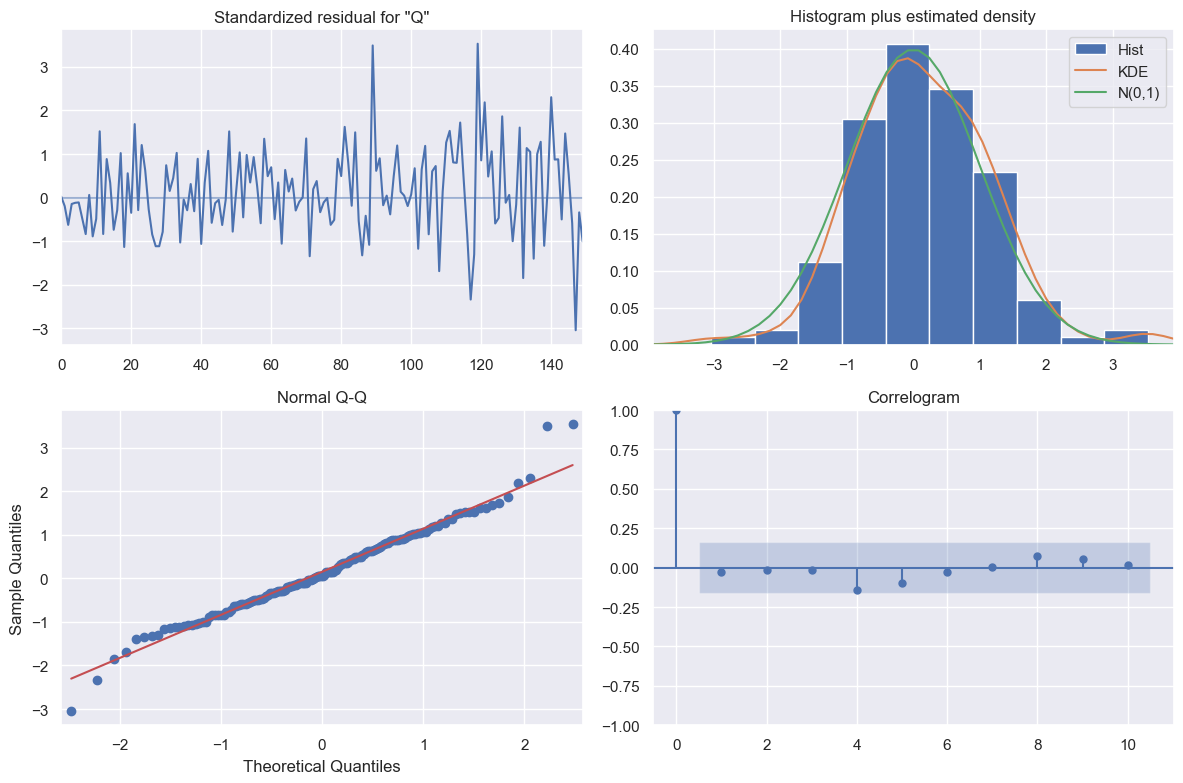

In [145]:
model.plot_diagnostics(figsize = (12,8))
plt.tight_layout()
plt.savefig('Images/Diagnostics/ARMIA_Coffee.png')
plt.show()

In [146]:
forecast = model.forecast(steps=len(df_test))
forecast.index = df_test['Date']

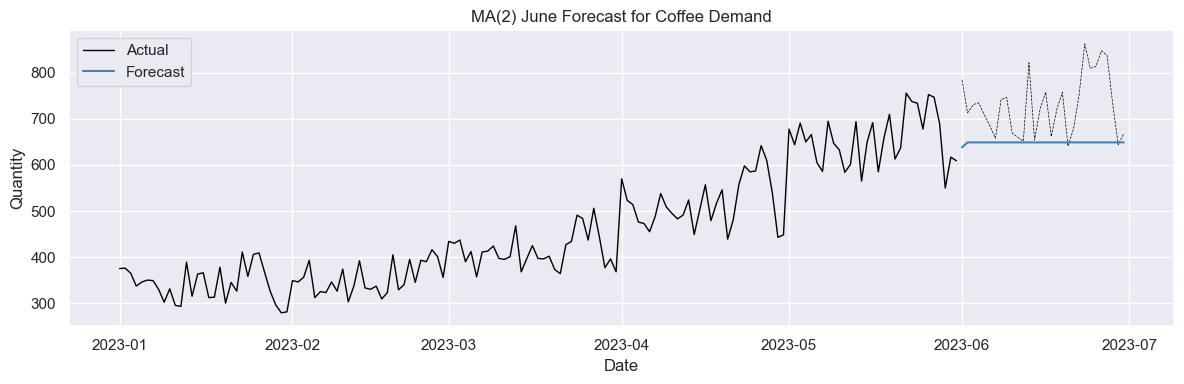

In [147]:
plt.figure(figsize=(12,4))


ax = sns.lineplot(data = df_train,x='Date',y='Quantity', label = "Actual",c='black', linewidth = 1)
ax = sns.lineplot(data = df_test,x='Date',y='Quantity', linestyle = '--', c='black', linewidth = 0.5)
ax = sns.lineplot(x=forecast.index, y=forecast, c='steelblue', label='Forecast')
ax.set(title = 'MA(2) June Forecast for Coffee Demand')

plt.tight_layout()
plt.savefig('Images/Forecasts/Coffee_ARIMA.png')

plt.show()

In [148]:
mape = mean_absolute_percentage_error(df_test['Quantity'], forecast) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 10.49%


### Box-Cox ARIMA

In [149]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [150]:
df_train_bc = df_train.copy()

df_train_bc['Transformed'],lam = boxcox(df_train['Quantity'])

df_train_bc

,Date,Quantity,Transformed
0,2023-01-01,375,1.267371
1,2023-01-02,376,1.267397
2,2023-01-03,365,1.267105
3,2023-01-04,337,1.266285
4,2023-01-05,346,1.266562
...,...,...,...
146,2023-05-27,747,1.272564
147,2023-05-28,689,1.272090
148,2023-05-29,550,1.270597
149,2023-05-30,617,1.271391


In [151]:
results_aic_bc = pm.auto_arima(df_train_bc['Transformed'], trace=True, information_criterion='aic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)
results_bic_bc = pm.auto_arima(df_train_bc['Transformed'], trace=True, information_criterion='bic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-1620.798, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-1654.518, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-1662.252, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-1664.931, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-1612.795, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-1610.798, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-1642.646, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-1653.272, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-1662.969, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-1661.757, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-1623.990, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-1649.111, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-1647.736, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-1660.356, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-1657.477, Time=0.25

In [152]:
model_bc = ARIMA(df_train_bc['Transformed'], order = (0,1,3)).fit()
print(model_bc.summary())

                               SARIMAX Results                                
Dep. Variable:            Transformed   No. Observations:                  151
Model:                 ARIMA(0, 1, 3)   Log Likelihood                 834.794
Date:                Sat, 15 Nov 2025   AIC                          -1661.587
Time:                        02:07:02   BIC                          -1649.545
Sample:                             0   HQIC                         -1656.695
                                - 151                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6001      0.085     -7.096      0.000      -0.766      -0.434
ma.L2         -0.0905      0.099     -0.914      0.361      -0.285       0.104
ma.L3         -0.0664      0.076     -0.880      0.3

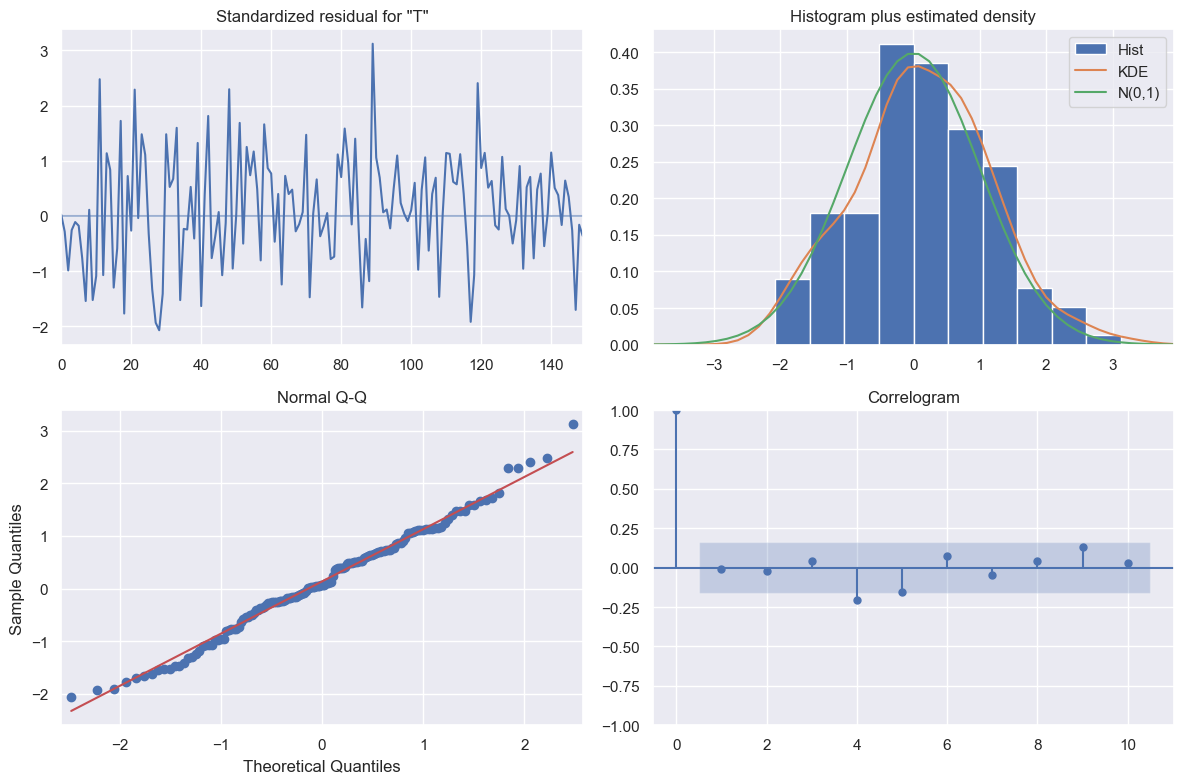

In [153]:
model_bc.plot_diagnostics(figsize = (12,8))
plt.tight_layout()
plt.savefig('Images/Diagnostics/ARMIA_BC_Coffee.png')
plt.show()

In [154]:
forecast_bc = model_bc.forecast(steps=len(df_test))
forecast.index = df_test['Date']

In [155]:
forecast_inv_transformed = inv_boxcox(forecast_bc,lam)

forecast_inv_transformed

151    639.194657
152    643.178798
153    645.406551
154    645.406551
155    645.406551
156    645.406551
157    645.406551
158    645.406551
159    645.406551
160    645.406551
161    645.406551
162    645.406551
163    645.406551
164    645.406551
165    645.406551
166    645.406551
167    645.406551
168    645.406551
169    645.406551
170    645.406551
171    645.406551
172    645.406551
173    645.406551
174    645.406551
175    645.406551
176    645.406551
177    645.406551
178    645.406551
179    645.406551
180    645.406551
Name: predicted_mean, dtype: float64

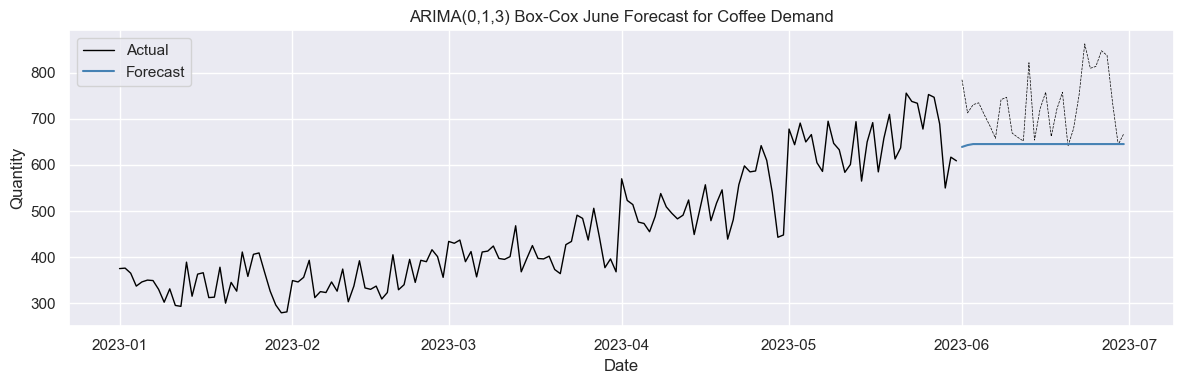

In [156]:
plt.figure(figsize=(12,4))


ax = sns.lineplot(data = df_train,x='Date',y='Quantity', label = "Actual",c='black', linewidth = 1)
ax = sns.lineplot(data = df_test,x='Date',y='Quantity', linestyle = '--', c='black', linewidth = 0.5)
ax = sns.lineplot(x=forecast.index, y=forecast_inv_transformed, c='steelblue', label='Forecast')
ax.set(title = 'ARIMA(0,1,3) Box-Cox June Forecast for Coffee Demand')

plt.tight_layout()
plt.savefig('Images/Forecasts/Coffee_BC_ARIMA.png')

plt.show()

In [157]:
mape_bc = mean_absolute_percentage_error(df_test['Quantity'], forecast_inv_transformed) * 100

print(f"MAPE: {mape_bc:.2f}%")

MAPE: 10.90%
